In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import copy
import time
from sklearn.preprocessing import StandardScaler
import random
from rnn_utils import *

In [2]:
class GRU_CUSTOM(object):

    def __init__(self, sizes, steps):
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        self.h0 = np.zeros((sizes[1],1))
        
        self.wz = np.random.randn(sizes[1],sizes[0])
        self.bwz = np.random.randn(sizes[1], 1)
        self.uz = np.random.randn(sizes[1],sizes[1])
        self.buz = np.random.randn(sizes[1], 1)
        
        self.wr = np.random.randn(sizes[1],sizes[0])
        self.bwr = np.random.randn(sizes[1], 1)
        self.ur = np.random.randn(sizes[1],sizes[1])
        self.bur = np.random.randn(sizes[1], 1)
        
        self.wh = np.random.randn(sizes[1],sizes[0])
        self.bwh = np.random.randn(sizes[1], 1)
        self.uh = np.random.randn(sizes[1],sizes[1])
        self.buh = np.random.randn(sizes[1], 1)
        
        self.wy = np.random.randn(sizes[2], sizes[1])
        self.by = np.random.randn(sizes[2], 1)     
        
        self.steps = steps

    def feedforward(self, x):
        h_next = self.h0
        for i in range(self.steps):
            zt = sigmoid(np.dot(self.wz, x[i].reshape(-1,1)) + self.bwz + np.dot(self.uz, h_next) + self.buz)
            rt = sigmoid(np.dot(self.wr, x[i].reshape(-1,1)) + self.bwr + np.dot(self.ur, h_next) + self.bur)
            nt = np.tanh(np.dot(self.wh, x[i].reshape(-1,1)) + self.bwh + rt*(np.dot(self.uh, h_next) + self.buh))
            h_next = (1-zt)*nt + zt*h_next
        result = sigmoid(np.dot(self.wy, h_next) + self.by).reshape(-1)
        return result 

    def score(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i])
            actual = y[i]
            total_score += np.sum(np.power(predicted-actual,2))  # mean-squared error
        return total_score/X.shape[0]

    def accuracy(self, X, y):
        accuracy = 0
        for i in range(X.shape[0]):
            output = self.feedforward(X[i])
            condition = True
            for j in range(len(output)):
                output[j] = round(output[j])
            for j in range(len(output)):
                if(output[j]!=y[i][j]):
                    condition = False
                    break
            if condition:
                accuracy += 1
        return accuracy / X.shape[0] * 100

In [3]:
class GRU_GA:

    def __init__(self, n_pops, net_size, mutation_rate, crossover_rate, X, y, X_test, y_test, steps):
        self.n_pops = n_pops
        self.steps = steps
        self.net_size = net_size
        self.nets = [GRU_CUSTOM(self.net_size,self.steps) for i in range(self.n_pops)]
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.X = X[:]
        self.y = y[:]
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        self.accuracy_train = []
        self.accuracy_test = []
        self.best = GRU_CUSTOM(self.net_size,self.steps)
    
    def get_random_point(self, type):
        nn = self.nets[0]
        point_index = 0
        if type == 'wz':
            row = random.randint(0,nn.wz.shape[0]-1)
            col = random.randint(0,nn.wz.shape[1]-1)
            point_index = (row, col)
        elif type == 'bwz':
            row = random.randint(0,nn.bwz.shape[0]-1)
            col = random.randint(0,nn.bwz.shape[1]-1)
            point_index = (row, col)
        elif type == 'uz':
            row = random.randint(0,nn.uz.shape[0]-1)
            col = random.randint(0,nn.uz.shape[1]-1)
            point_index = (row, col)
        elif type == 'buz':
            row = random.randint(0,nn.buz.shape[0]-1)
            col = random.randint(0,nn.buz.shape[1]-1)
            point_index = (row, col)
            
        if type == 'wr':
            row = random.randint(0,nn.wr.shape[0]-1)
            col = random.randint(0,nn.wr.shape[1]-1)
            point_index = (row, col)
        elif type == 'bwr':
            row = random.randint(0,nn.bwr.shape[0]-1)
            col = random.randint(0,nn.bwr.shape[1]-1)
            point_index = (row, col)
        elif type == 'ur':
            row = random.randint(0,nn.ur.shape[0]-1)
            col = random.randint(0,nn.ur.shape[1]-1)
            point_index = (row, col)
        elif type == 'bur':
            row = random.randint(0,nn.bur.shape[0]-1)
            col = random.randint(0,nn.bur.shape[1]-1)
            point_index = (row, col)
            
        if type == 'wh':
            row = random.randint(0,nn.wh.shape[0]-1)
            col = random.randint(0,nn.wh.shape[1]-1)
            point_index = (row, col)
        elif type == 'bwh':
            row = random.randint(0,nn.bwh.shape[0]-1)
            col = random.randint(0,nn.bwh.shape[1]-1)
            point_index = (row, col)
        elif type == 'uh':
            row = random.randint(0,nn.uh.shape[0]-1)
            col = random.randint(0,nn.uh.shape[1]-1)
            point_index = (row, col)
        elif type == 'buh':
            row = random.randint(0,nn.buh.shape[0]-1)
            col = random.randint(0,nn.buh.shape[1]-1)
            point_index = (row, col)
            
        elif type == 'wy':
            row = random.randint(0,nn.wy.shape[0]-1)
            col = random.randint(0,nn.wy.shape[1]-1)
            point_index = (row, col)
        elif type == 'by':
            row = random.randint(0,nn.by.shape[0]-1)
            col = random.randint(0,nn.by.shape[1]-1)
            point_index = (row, col)
        return point_index

    def get_all_scores(self,Xc,yc):
        return [net.score(Xc,yc) for net in self.nets]

    def get_all_accuracy(self,Xc,yc):
        return [net.accuracy(Xc,yc) for net in self.nets]

    def crossover(self):
        for i in range(self.n_pops):
            if random.uniform(0,1) < self.crossover_rate:
                father = random.randint(0,self.n_pops-1)
                mother = random.randint(0,self.n_pops-1)
                nn_1 = copy.deepcopy(self.nets[father])
                nn_2 = copy.deepcopy(self.nets[mother])
                
                k_1 = random.randint(int(0.5*self.nets[0].wz.size),self.nets[0].wz.size)
                for _ in range(k_1):
                    point = self.get_random_point('wz')
                    nn_1.wz[point] = self.nets[mother].wz[point]
                    nn_2.wz[point] = self.nets[father].wz[point]
                    
                k_2 = random.randint(int(0.5*self.nets[0].bwz.size),self.nets[0].bwz.size)
                for _ in range(k_2):
                    point = self.get_random_point('bwz')
                    nn_1.bwz[point] = self.nets[mother].bwz[point]
                    nn_2.bwz[point] = self.nets[father].bwz[point]
                    
                k_3 = random.randint(int(0.5*self.nets[0].uz.size),self.nets[0].uz.size)
                for _ in range(k_3):
                    point = self.get_random_point('uz')
                    nn_1.uz[point] = self.nets[mother].uz[point]
                    nn_2.uz[point] = self.nets[father].uz[point]
                    
                k_4 = random.randint(int(0.5*self.nets[0].buz.size),self.nets[0].buz.size)
                for _ in range(k_4):
                    point = self.get_random_point('buz')
                    nn_1.buz[point] = self.nets[mother].buz[point]
                    nn_2.buz[point] = self.nets[father].buz[point]
                    
                k_5 = random.randint(int(0.5*self.nets[0].wr.size),self.nets[0].wr.size)
                for _ in range(k_5):
                    point = self.get_random_point('wr')
                    nn_1.wr[point] = self.nets[mother].wr[point]
                    nn_2.wr[point] = self.nets[father].wr[point]
                
                k_6 = random.randint(int(0.5*self.nets[0].bwr.size),self.nets[0].bwr.size)
                for _ in range(k_6):
                    point = self.get_random_point('bwr')
                    nn_1.bwr[point] = self.nets[mother].bwr[point]
                    nn_2.bwr[point] = self.nets[father].bwr[point]
                
                k_7 = random.randint(int(0.5*self.nets[0].ur.size),self.nets[0].ur.size)
                for _ in range(k_7):
                    point = self.get_random_point('ur')
                    nn_1.ur[point] = self.nets[mother].ur[point]
                    nn_2.ur[point] = self.nets[father].ur[point]
                
                k_8 = random.randint(int(0.5*self.nets[0].bur.size),self.nets[0].bur.size)
                for _ in range(k_8):
                    point = self.get_random_point('bur')
                    nn_1.bur[point] = self.nets[mother].bur[point]
                    nn_2.bur[point] = self.nets[father].bur[point]
                
                k_9 = random.randint(int(0.5*self.nets[0].wh.size),self.nets[0].wh.size)
                for _ in range(k_9):
                    point = self.get_random_point('wh')
                    nn_1.wh[point] = self.nets[mother].wh[point]
                    nn_2.wh[point] = self.nets[father].wh[point]
                
                k_10 = random.randint(int(0.5*self.nets[0].bwh.size),self.nets[0].bwh.size)
                for _ in range(k_10):
                    point = self.get_random_point('bwh')
                    nn_1.bwh[point] = self.nets[mother].bwh[point]
                    nn_2.bwh[point] = self.nets[father].bwh[point]
                    
                k_11 = random.randint(int(0.5*self.nets[0].uh.size),self.nets[0].uh.size)
                for _ in range(k_11):
                    point = self.get_random_point('uh')
                    nn_1.uh[point] = self.nets[mother].uh[point]
                    nn_2.uh[point] = self.nets[father].uh[point]
                
                k_12 = random.randint(int(0.5*self.nets[0].buh.size),self.nets[0].buh.size)
                for _ in range(k_12):
                    point = self.get_random_point('buh')
                    nn_1.buh[point] = self.nets[mother].buh[point]
                    nn_2.buh[point] = self.nets[father].buh[point]
                
                k_13 = random.randint(int(0.5*self.nets[0].wy.size),self.nets[0].wy.size)
                for _ in range(k_13):
                    point = self.get_random_point('wy')
                    nn_1.wy[point] = self.nets[mother].wy[point]
                    nn_2.wy[point] = self.nets[father].wy[point]
                
                k_14 = random.randint(int(0.5*self.nets[0].by.size),self.nets[0].by.size)
                for _ in range(k_14):
                    point = self.get_random_point('by')
                    nn_1.by[point] = self.nets[mother].by[point]
                    nn_2.by[point] = self.nets[father].by[point]
                
                self.nets.append(copy.deepcopy(nn_1))
                self.nets.append(copy.deepcopy(nn_2))
        
    def mutation(self):
        for i in range(self.n_pops):
            if random.uniform(0,1) < self.mutation_rate:
                origin = random.randint(0,self.n_pops-1)
                nn = copy.deepcopy(self.nets[origin])

                k_1 = random.randint(int(0.5*self.nets[0].wz.size),self.nets[0].wz.size)
                for _ in range(k_1):
                    point = self.get_random_point('wz')
                    nn.wz[point] += random.uniform(-0.5, 0.5)

                k_2 = random.randint(int(0.5*self.nets[0].bwz.size),self.nets[0].bwz.size)
                for _ in range(k_2):
                    point = self.get_random_point('bwz')
                    nn.bwz[point] += random.uniform(-0.5, 0.5)
                    
                k_3 = random.randint(int(0.5*self.nets[0].uz.size),self.nets[0].uz.size)
                for _ in range(k_3):
                    point = self.get_random_point('uz')
                    nn.uz[point] += random.uniform(-0.5, 0.5)
                    
                k_4 = random.randint(int(0.5*self.nets[0].buz.size),self.nets[0].buz.size)
                for _ in range(k_4):
                    point = self.get_random_point('buz')
                    nn.buz[point] += random.uniform(-0.5, 0.5)
                    
                k_5 = random.randint(int(0.5*self.nets[0].wr.size),self.nets[0].wr.size)
                for _ in range(k_5):
                    point = self.get_random_point('wr')
                    nn.wr[point] += random.uniform(-0.5, 0.5)
                
                k_6 = random.randint(int(0.5*self.nets[0].bwr.size),self.nets[0].bwr.size)
                for _ in range(k_6):
                    point = self.get_random_point('bwr')
                    nn.bwr[point] += random.uniform(-0.5, 0.5)

                k_7 = random.randint(int(0.5*self.nets[0].ur.size),self.nets[0].ur.size)
                for _ in range(k_7):
                    point = self.get_random_point('ur')
                    nn.ur[point] += random.uniform(-0.5, 0.5)
                    
                k_8 = random.randint(int(0.5*self.nets[0].bur.size),self.nets[0].bur.size)
                for _ in range(k_8):
                    point = self.get_random_point('bur')
                    nn.bur[point] += random.uniform(-0.5, 0.5)
                
                k_9 = random.randint(int(0.5*self.nets[0].wh.size),self.nets[0].wh.size)
                for _ in range(k_9):
                    point = self.get_random_point('wh')
                    nn.wh[point] += random.uniform(-0.5, 0.5)
                
                k_10 = random.randint(int(0.5*self.nets[0].bwh.size),self.nets[0].bwh.size)
                for _ in range(k_10):
                    point = self.get_random_point('bwh')
                    nn.bwh[point] += random.uniform(-0.5, 0.5)

                k_11 = random.randint(int(0.5*self.nets[0].uh.size),self.nets[0].uh.size)
                for _ in range(k_11):
                    point = self.get_random_point('uh')
                    nn.uh[point] += random.uniform(-0.5, 0.5)
                    
                k_12 = random.randint(int(0.5*self.nets[0].buh.size),self.nets[0].buh.size)
                for _ in range(k_12):
                    point = self.get_random_point('buh')
                    nn.buh[point] += random.uniform(-0.5, 0.5)
                    
                k_13 = random.randint(int(0.5*self.nets[0].wy.size),self.nets[0].wy.size)
                for _ in range(k_13):
                    point = self.get_random_point('wy')
                    nn.wy[point] += random.uniform(-0.5, 0.5)
                    
                k_14 = random.randint(int(0.5*self.nets[0].by.size),self.nets[0].by.size)
                for _ in range(k_14):
                    point = self.get_random_point('by')
                    nn.by[point] += random.uniform(-0.5, 0.5)
                self.nets.append(copy.deepcopy(nn))
        
    def selection(self,Xc,yc):
        nets_new=[]
        for i in range(self.n_pops):
            k_1 = random.randint(0,len(self.nets)-1)
            k_2 = random.randint(0,len(self.nets)-1)
            if(self.nets[k_1].score(Xc,yc)<self.nets[k_2].score(Xc,yc)):
                nets_new.append(self.nets[k_1])
            else:
                nets_new.append(self.nets[k_2])
        self.nets = copy.deepcopy(nets_new)
    
    def sort_nets(self,Xc,yc):
        score_list = list(zip(self.nets, self.get_all_scores(Xc,yc)))
        score_list.sort(key=lambda x: x[1])
        score_list = [obj[0] for obj in score_list]
        self.nets = copy.deepcopy(score_list)
        if(self.best.accuracy(self.X,self.y)<self.nets[0].accuracy(self.X,self.y)):
            self.best = copy.deepcopy(self.nets[0])

    def evolve(self):
        start_time = time.time()
        for t in range(10):
            self.accuracy_train.append(self.best.accuracy(self.X,self.y))
            self.accuracy_test.append(self.best.accuracy(self.X_test,self.y_test))
            for i in range(20):
                j1=i*40
                j2=(1+i)*40
                Xc=self.X[j1:j2,:,:]
                yc=self.y[j1:j2,:]
                for k in range(25): 
                    self.crossover()
                    self.mutation()
                    self.selection(Xc,yc)
                    self.sort_nets(Xc,yc)
                print("Current iteration : {}, batch : {}".format(t+1,i+1))
                print("Time taken by far : %.1f seconds" % (time.time() - start_time))
                print("Current top member's network score: %.5f " % self.best.score(self.X,self.y))
                print("Current top member's network accuracy: %.2f%%\n" % self.best.accuracy(self.X,self.y))

In [4]:
df = pd.read_csv("../Data/data_(8-8).csv")
sc = StandardScaler()

In [5]:
X = df.iloc[:800, :8].values
y = df.iloc[:800, 8:16].values
X = sc.fit_transform(X)
X_test = df.iloc[800:1000, :8].values
y_test = df.iloc[800:1000, 8:16].values
X_test = sc.fit_transform(X_test)

In [6]:
X1= np.reshape(X, (X.shape[0], X.shape[1], 1))
y1= np.reshape(y, (y.shape[0], y.shape[1]))

In [7]:
X2= np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y2= np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

In [8]:
N_POPS = 100
steps = X.shape[1]
NET_SIZE = [1,24,8]
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.8
gru_ga = GRU_GA(N_POPS, NET_SIZE, MUTATION_RATE, CROSSOVER_RATE, X1, y1, X2, y2, steps)
gru_ga.evolve()

Current iteration : 1, batch : 1
Time taken by far : 110.0 seconds
Current top member's network score: 1.81429 
Current top member's network accuracy: 18.88%

Current iteration : 1, batch : 2
Time taken by far : 230.8 seconds
Current top member's network score: 1.81429 
Current top member's network accuracy: 18.88%

Current iteration : 1, batch : 3
Time taken by far : 350.1 seconds
Current top member's network score: 1.73877 
Current top member's network accuracy: 25.12%

Current iteration : 1, batch : 4
Time taken by far : 474.9 seconds
Current top member's network score: 1.73877 
Current top member's network accuracy: 25.12%

Current iteration : 1, batch : 5
Time taken by far : 590.9 seconds
Current top member's network score: 1.73877 
Current top member's network accuracy: 25.12%

Current iteration : 1, batch : 6
Time taken by far : 688.1 seconds
Current top member's network score: 1.73877 
Current top member's network accuracy: 25.12%

Current iteration : 1, batch : 7
Time taken by

Current top member's network accuracy: 35.62%

Current iteration : 3, batch : 13
Time taken by far : 4617.0 seconds
Current top member's network score: 1.02255 
Current top member's network accuracy: 35.62%

Current iteration : 3, batch : 14
Time taken by far : 4697.3 seconds
Current top member's network score: 1.02255 
Current top member's network accuracy: 35.62%

Current iteration : 3, batch : 15
Time taken by far : 4777.3 seconds
Current top member's network score: 1.02255 
Current top member's network accuracy: 35.62%

Current iteration : 3, batch : 16
Time taken by far : 4856.3 seconds
Current top member's network score: 1.02432 
Current top member's network accuracy: 37.88%

Current iteration : 3, batch : 17
Time taken by far : 4935.3 seconds
Current top member's network score: 1.02432 
Current top member's network accuracy: 37.88%

Current iteration : 3, batch : 18
Time taken by far : 5015.6 seconds
Current top member's network score: 1.05260 
Current top member's network accur

Current iteration : 6, batch : 4
Time taken by far : 9123.7 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 5
Time taken by far : 9205.4 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 6
Time taken by far : 9291.7 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 7
Time taken by far : 9385.6 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 8
Time taken by far : 9470.0 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 9
Time taken by far : 9558.0 seconds
Current top member's network score: 1.00173 
Current top member's network accuracy: 44.12%

Current iteration : 6, batch : 10
Time t

Current iteration : 8, batch : 15
Time taken by far : 13430.6 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 8, batch : 16
Time taken by far : 13511.4 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 8, batch : 17
Time taken by far : 13591.4 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 8, batch : 18
Time taken by far : 13671.9 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 8, batch : 19
Time taken by far : 13752.5 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 8, batch : 20
Time taken by far : 13832.6 seconds
Current top member's network score: 0.97135 
Current top member's network accuracy: 48.00%

Current iteration : 9, batch

In [9]:
gru_ga.best.accuracy(X1,y1)

48.0

In [10]:
gru_ga.best.accuracy(X2,y2)

38.0

In [11]:
accuracy_train = np.array(gru_ga.accuracy_train)
accuracy_test = np.array(gru_ga.accuracy_test)

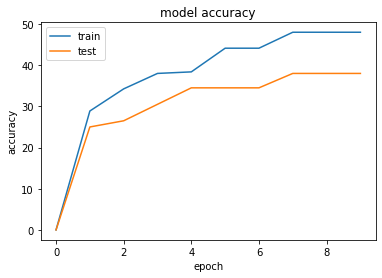

In [12]:
plt.plot(accuracy_train)
plt.plot(accuracy_test )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()